In [75]:
# standard library imports
import os

# third-party imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsOneClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay, classification_report, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

# local application/library specific imports
from tensorflow import keras
from keras.datasets import fashion_mnist
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions


# Preprocess the dataset

In [76]:
#load dataset from kaggle
df = pd.read_csv('D:\seng474\images.csv')
display(df)

,image,sender_id,label,kids
0,4285fab0-751a-4b74-8e9b-43af05deee22,124,Not sure,False
1,ea7b6656-3f84-4eb3-9099-23e623fc1018,148,T-Shirt,False
2,00627a3f-0477-401c-95eb-92642cbe078d,94,Not sure,False
3,ea2ffd4d-9b25-4ca8-9dc2-bd27f1cc59fa,43,T-Shirt,False
4,3b86d877-2b9e-4c8b-a6a2-1d87513309d0,189,Shoes,False
...,...,...,...,...
5398,dfd4079d-967b-4b3e-8574-fbac11b58103,204,Shorts,False
5399,befa14be-8140-4faf-8061-1039947e329d,204,Body,True
5400,5379356a-40ee-4890-b416-2336a7d84061,310,Shorts,False
5401,65507fb8-3456-4c15-b53e-d1b03bf71a59,204,Shoes,False


In [77]:
#Load the Fashion-MNIST dataset and split into train and test
(xTrain,yTrain), (xTest,yTest) = fashion_mnist.load_data()
#reshape the xTrain
xTrain = np.reshape(xTrain,(xTrain.shape[0],xTrain.shape[1]*xTrain.shape[2]))

In [78]:
#get T-shirt(0),trouser(1),pullover(2),dress(3),coat(4),shirt(6),sneaker(7) from xTrain and yTrain
x_fm = []
y_fm = []
for i in range(yTrain.size):
    if yTrain[i] in [0,1,2,3,4,6,7]:
        x_fm.append(xTrain[i])
        y_fm.append(yTrain[i])
x_fm = np.array(x_fm)
y_fm = np.array(y_fm)
np.unique(y_fm)

array([0, 1, 2, 3, 4, 6, 7], dtype=uint8)

In [79]:
print(y_fm.size)

42000


In [80]:
y_fm[y_fm==0]=0  #T-shirt
y_fm[y_fm==1]=1  #Trouser
y_fm[y_fm==2]=2  #Pullover
y_fm[y_fm==3]=3  #Dress
y_fm[y_fm==4]=4  #Coat
y_fm[y_fm==6]=5  #Shirt
y_fm[y_fm==7]=6  #Sneaker


In [81]:
ss = StandardScaler()
x_fm = ss.fit_transform(x_fm)

In [82]:
df["label"].value_counts()

label
T-Shirt       1011
Longsleeve     699
Pants          692
Shoes          431
Shirt          378
Dress          357
Outwear        312
Shorts         308
Not sure       228
Hat            171
Skirt          155
Polo           120
Undershirt     118
Blazer         109
Hoodie         100
Body            69
Other           67
Top             43
Blouse          23
Skip            12
Name: count, dtype: int64

In [83]:
df1=df[['image','label']]
df1

,image,label
0,4285fab0-751a-4b74-8e9b-43af05deee22,Not sure
1,ea7b6656-3f84-4eb3-9099-23e623fc1018,T-Shirt
2,00627a3f-0477-401c-95eb-92642cbe078d,Not sure
3,ea2ffd4d-9b25-4ca8-9dc2-bd27f1cc59fa,T-Shirt
4,3b86d877-2b9e-4c8b-a6a2-1d87513309d0,Shoes
...,...,...
5398,dfd4079d-967b-4b3e-8574-fbac11b58103,Shorts
5399,befa14be-8140-4faf-8061-1039947e329d,Body
5400,5379356a-40ee-4890-b416-2336a7d84061,Shorts
5401,65507fb8-3456-4c15-b53e-d1b03bf71a59,Shoes


In [84]:
path = 'D:\seng474\images_original'

files= os.listdir(path)

In [85]:
#preprocess(read pic)
h = 28
w = 28
x = []
y = []
for f in files:
    img = cv2.imread(path+'/'+f, cv2.IMREAD_GRAYSCALE)
    pic = f.replace('.jpg', '')
    for i, label in enumerate(df1['image']):
        if label == pic:
            # background remove 
            _, binary_img = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
            segmented_img = cv2.bitwise_and(img, img, mask=binary_img)

            resized_img = cv2.resize(segmented_img, (h, w))
            x.append(resized_img.flatten())
            y.append(df1.loc[i, 'label'])  # Assuming df1 is a DataFrame with 'label' column
    
x = np.array(x)
y = np.array(y)


In [86]:
# Vertical rotate
flip_x = []
for image in x:
    flipped_image = cv2.flip(image, 1)  
    
    flip_x.append(flipped_image.reshape(-1))

flipped_x = np.array(flip_x)


In [87]:
flipped_x1 = flipped_x.reshape(-1)

In [88]:
print (flipped_x1.size)
print (x.size)
x.ndim
y.size

4235952
4235952


5403

In [89]:
flipped_x[0]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   

In [90]:
data = np.array(x[0])
print (data.ndim)

1


In [91]:
print (x[0])

[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 158 161
 160 154 128 192 144 171 160 175 127   0   0   0   

In [92]:
print(y)

['T-Shirt' 'Hoodie' 'Polo' ... 'Pants' 'Pants' 'Outwear']


In [93]:
data = []
data_label = []
for i in range(y.size):
    if y[i] in ['T-Shirt','Pants','Longsleeve','Dress','Outwear','Shirt','Shoes']:
        data.append(flipped_x[i])
        data_label.append(y[i])
np.unique(data_label)

len(data)

3880

In [94]:
flip_data = []
flip_data_label = []
for i in range(y.size):
    if y[i] in ['T-Shirt','Pants','Longsleeve','Dress','Outwear','Shirt','Shoes']:
        flip_data.append(x[i])
        flip_data_label.append(y[i])
# flip_data=np.array(flip_data)
# data_label=np.array(data_label)
np.unique(data_label)
len(flip_data)

3880

In [95]:
Merge_data = data + flip_data
Merge_data_label = data_label + flip_data_label

Merge_data = np.array(Merge_data)
Merge_data_label = np.array(Merge_data_label)

In [96]:
data=np.array(data)
data_label=np.array(data_label)

flip_data=np.array(flip_data)
flip_data_label=np.array(flip_data_label)

In [97]:
Merge_data_label[Merge_data_label=='T-Shirt']=0    #T-Shirt
Merge_data_label[Merge_data_label=='Pants']=1      #Trouser 
Merge_data_label[Merge_data_label=='Longsleeve']=2 #Pullover
Merge_data_label[Merge_data_label=='Dress']=3      #Dress
Merge_data_label[Merge_data_label=='Outwear']=4    #Coat
Merge_data_label[Merge_data_label=='Shirt']=5      #Shirt
Merge_data_label[Merge_data_label=='Shoes']=6      #Sneaker
#data_label[data_label=='Hat']=7



In [98]:
ss = StandardScaler()
data = ss.fit_transform(Merge_data)



In [99]:
Merge_data_label=Merge_data_label.reshape(Merge_data_label.shape[0]).astype('int')

In [100]:
data_label.size

3880

# Train and test on the dataset from kaggle

In [101]:
#split the data into train and test
train_x,test_x,train_y,test_y=train_test_split(Merge_data, Merge_data_label, test_size = 0.2, random_state=42)

In [102]:
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, Add, Flatten, Dense, MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Input layer
inputs = Input(shape=(28, 28, 1))

# First block
conv1 = Conv2D(32, 3, activation='relu', padding='same')(inputs)
conv2 = Conv2D(32, 3, activation='relu', padding='same')(conv1)
block1_output = MaxPooling2D(3)(conv2)

# Second block
conv3 = Conv2D(32, 3, activation='relu', padding='same')(block1_output)
conv4 = Conv2D(32, 3, activation='relu', padding='same')(conv3)
block2_output = Add()([conv4, block1_output])

# Third block
conv5 = Conv2D(32, 3, activation='relu', padding='same')(block2_output)
conv6 = Conv2D(32, 3, activation='relu', padding='same')(conv5)
block3_output = Add()([conv6, block2_output])

# Classification head
x = Flatten()(block3_output)
x = Dense(128, activation='relu')(x)
predictions = Dense(len(np.unique(train_y)), activation='softmax')(x)

# Create and compile model
model = Model(inputs=inputs, outputs=predictions)
model.compile(optimizer=Adam(lr=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Reshape data to match the input shape of the model
train_x = train_x.reshape(-1, 28, 28, 1)
test_x = test_x.reshape(-1, 28, 28, 1)

# Train the model
history = model.fit(train_x, train_y, epochs=5, validation_data=(test_x, test_y))
history


Epoch 1/5
194/194 [==============================] - 6s 24ms/step - loss: 4.9459 - accuracy: 0.4389 - val_loss: 1.0484 - val_accuracy: 0.6340
Epoch 2/5
194/194 [==============================] - 5s 24ms/step - loss: 0.8086 - accuracy: 0.7239 - val_loss: 0.6691 - val_accuracy: 0.7680
Epoch 3/5
194/194 [==============================] - 5s 25ms/step - loss: 0.3807 - accuracy: 0.8777 - val_loss: 0.5073 - val_accuracy: 0.8383
Epoch 4/5
194/194 [==============================] - 5s 27ms/step - loss: 0.1565 - accuracy: 0.9567 - val_loss: 0.3624 - val_accuracy: 0.8950
Epoch 5/5
194/194 [==============================] - 5s 27ms/step - loss: 0.0470 - accuracy: 0.9908 - val_loss: 0.3543 - val_accuracy: 0.9214


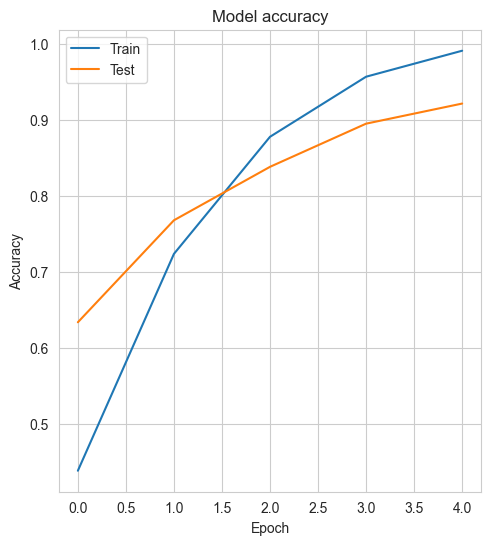

In [103]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

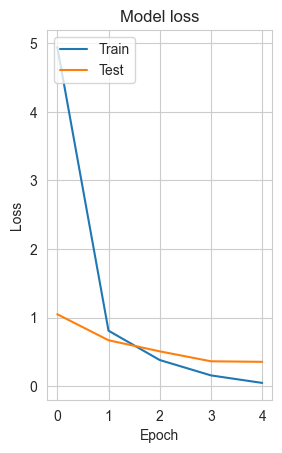

In [104]:
# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()

49/49 [==============================] - 0s 5ms/step
              precision    recall  f1-score   support

           0       0.95      0.93      0.94       399
           1       0.96      0.98      0.97       273
           2       0.86      0.96      0.91       275
           3       0.91      0.91      0.91       152
           4       0.88      0.88      0.88       129
           5       0.91      0.86      0.89       145
           6       0.95      0.85      0.90       179

    accuracy                           0.92      1552
   macro avg       0.92      0.91      0.91      1552
weighted avg       0.92      0.92      0.92      1552



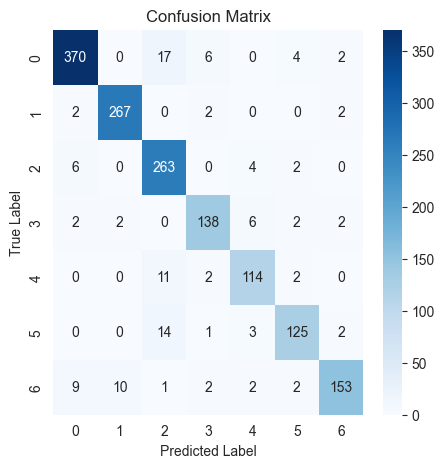

In [105]:
# Predict classes
pred_classes = np.argmax(model.predict(test_x), axis=-1)

# Print the Classification Report
print(classification_report(test_y, pred_classes))

# Create the Confusion Matrix
cm = confusion_matrix(test_y, pred_classes)

# Display the Confusion Matrix
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Train on kaggle dataset and test on fashion mnist dataset

In [106]:
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, Add, Flatten, Dense, MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import numpy as np

# Input layer
inputs = Input(shape=(28, 28, 1))

# First block
conv1 = Conv2D(32, 3, activation='relu', padding='same')(inputs)
conv2 = Conv2D(32, 3, activation='relu', padding='same')(conv1)
block1_output = MaxPooling2D(3)(conv2)

# Second block
conv3 = Conv2D(32, 3, activation='relu', padding='same')(block1_output)
conv4 = Conv2D(32, 3, activation='relu', padding='same')(conv3)
block2_output = Add()([conv4, block1_output])

# Third block
conv5 = Conv2D(32, 3, activation='relu', padding='same')(block2_output)
conv6 = Conv2D(32, 3, activation='relu', padding='same')(conv5)
block3_output = Add()([conv6, block2_output])

# Classification head
x = Flatten()(block3_output)
x = Dense(128, activation='relu')(x)
predictions = Dense(len(np.unique(train_y)), activation='softmax')(x)

# Create and compile the model
model = Model(inputs=inputs, outputs=predictions)
model.compile(optimizer=Adam(lr=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Reshape data to match the input shape of the model
train_x = train_x.reshape(-1, 28, 28, 1)
test_x = test_x.reshape(-1, 28, 28, 1)

# Train the model on the Kaggle dataset
history = model.fit(train_x, train_y, epochs=5,validation_data=(test_x, test_y))



Epoch 1/5
194/194 [==============================] - 6s 26ms/step - loss: 3.9685 - accuracy: 0.4832 - val_loss: 0.9487 - val_accuracy: 0.6656
Epoch 2/5
194/194 [==============================] - 5s 25ms/step - loss: 0.6552 - accuracy: 0.7759 - val_loss: 0.6356 - val_accuracy: 0.7893
Epoch 3/5
194/194 [==============================] - 5s 26ms/step - loss: 0.2661 - accuracy: 0.9225 - val_loss: 0.4379 - val_accuracy: 0.8898
Epoch 4/5
194/194 [==============================] - 5s 26ms/step - loss: 0.0871 - accuracy: 0.9805 - val_loss: 0.3248 - val_accuracy: 0.9336
Epoch 5/5
194/194 [==============================] - 5s 26ms/step - loss: 0.0235 - accuracy: 0.9965 - val_loss: 0.3786 - val_accuracy: 0.9323


In [107]:
# Evaluate the model on the Fashion MNIST dataset
loss, accuracy = model.evaluate(test_x, test_y)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

49/49 [==============================] - 0s 7ms/step - loss: 0.3786 - accuracy: 0.9323
Test Loss: 0.3786
Test Accuracy: 0.9323


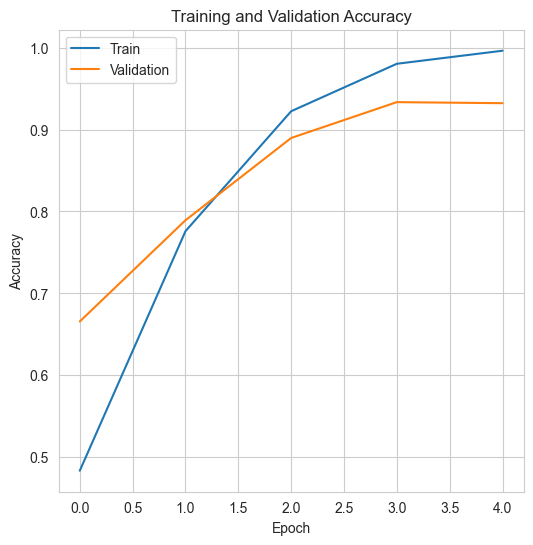

In [108]:
# Plot the training and validation accuracy
plt.figure(figsize=(6, 6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

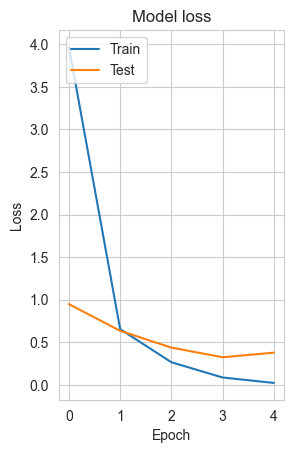

In [109]:
# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()

49/49 [==============================] - 0s 5ms/step
              precision    recall  f1-score   support

           0       0.95      0.92      0.94       399
           1       0.99      0.96      0.97       273
           2       0.90      0.97      0.93       275
           3       0.92      0.86      0.88       152
           4       0.89      0.91      0.90       129
           5       0.84      0.89      0.87       145
           6       0.99      0.97      0.98       179

    accuracy                           0.93      1552
   macro avg       0.92      0.92      0.92      1552
weighted avg       0.93      0.93      0.93      1552



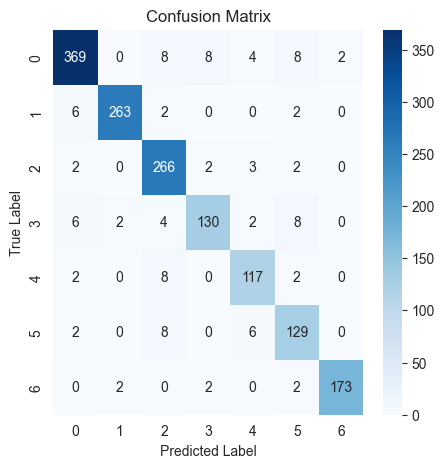

In [110]:
# Predict classes
pred_classes = np.argmax(model.predict(test_x), axis=-1)

# Print the Classification Report
print(classification_report(test_y, pred_classes))

# Create the Confusion Matrix
cm = confusion_matrix(test_y, pred_classes)

# Display the Confusion Matrix
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Train and test on fashion mnist dataset

In [111]:
#split the data into train and test
train_x,test_x,train_y,test_y=train_test_split(x_fm, y_fm, test_size = 0.2, random_state = 42,stratify=y_fm)

In [112]:
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import numpy as np

# Define the RegNet architecture
inputs = Input(shape=(28, 28, 1))
x = Conv2D(32, 3, activation='relu', padding='same')(inputs)
x = BatchNormalization()(x)
x = Conv2D(32, 3, activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = GlobalAveragePooling2D()(x)
x = Dense(64, activation='relu')(x)
predictions = Dense(10, activation='softmax')(x)

model = Model(inputs=inputs, outputs=predictions)
model.compile(optimizer=Adam(lr=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Reshape data to match the input shape of the model
train_x = train_x.reshape(-1, 28, 28, 1)
test_x = test_x.reshape(-1, 28, 28, 1)

# Train the model on the Fashion MNIST dataset
history = model.fit(train_x, train_y, epochs=5,validation_data=(test_x, test_y))

# Evaluate the model on the Fashion MNIST test dataset
loss, accuracy = model.evaluate(test_x, test_y)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")


Epoch 1/5
1050/1050 [==============================] - 25s 23ms/step - loss: 0.9420 - accuracy: 0.6430 - val_loss: 0.9012 - val_accuracy: 0.6607
Epoch 2/5
1050/1050 [==============================] - 26s 25ms/step - loss: 0.6289 - accuracy: 0.7594 - val_loss: 0.5684 - val_accuracy: 0.7864
Epoch 3/5
1050/1050 [==============================] - 25s 24ms/step - loss: 0.5293 - accuracy: 0.8015 - val_loss: 1.0020 - val_accuracy: 0.6395
Epoch 4/5
1050/1050 [==============================] - 25s 24ms/step - loss: 0.4811 - accuracy: 0.8198 - val_loss: 0.4921 - val_accuracy: 0.8129
Epoch 5/5
263/263 [==============================] - 1s 6ms/step - loss: 0.4883 - accuracy: 0.8114
Test Loss: 0.4883
Test Accuracy: 0.8114


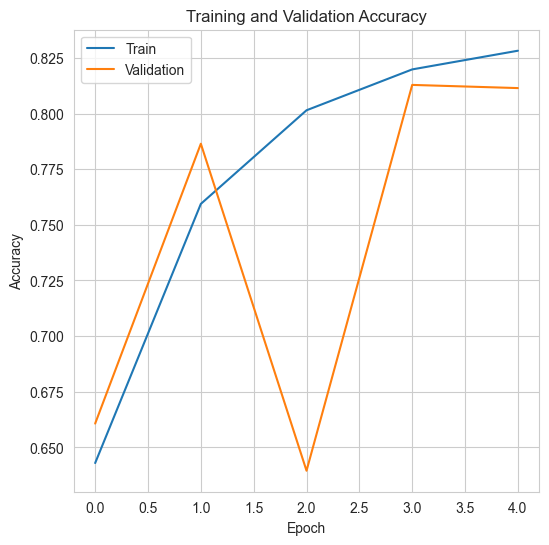

In [113]:
# Plot the training and validation accuracy
plt.figure(figsize=(6, 6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

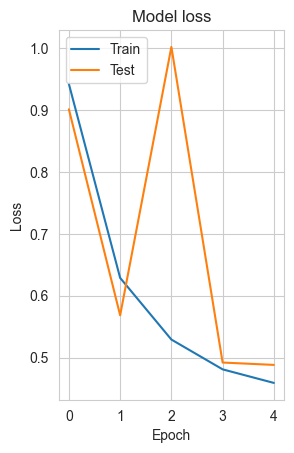

In [114]:
# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()

263/263 [==============================] - 2s 5ms/step
              precision    recall  f1-score   support

           0       0.84      0.77      0.80      1200
           1       0.86      0.98      0.91      1200
           2       0.81      0.77      0.79      1200
           3       0.87      0.76      0.81      1200
           4       0.77      0.67      0.72      1200
           5       0.60      0.74      0.66      1200
           6       0.99      1.00      0.99      1200

    accuracy                           0.81      8400
   macro avg       0.82      0.81      0.81      8400
weighted avg       0.82      0.81      0.81      8400



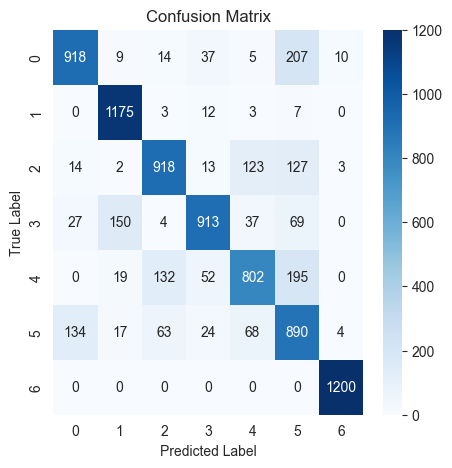

In [115]:
# Predict classes
pred_classes = np.argmax(model.predict(test_x), axis=-1)

# Print the Classification Report
print(classification_report(test_y, pred_classes))

# Create the Confusion Matrix
cm = confusion_matrix(test_y, pred_classes)

# Display the Confusion Matrix
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Combine the two datasets together

In [116]:
y_combine = np.hstack((y_fm[:3880],Merge_data_label))
x_combine = np.vstack((x_fm[:3880],Merge_data))

In [117]:
#split the data into train and test
train_x,test_x,train_y,test_y=train_test_split(x_combine, y_combine, test_size = 0.2, random_state = 42)

In [118]:
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Reshape data to match the input shape of the model
train_x = train_x.reshape(-1, 28, 28, 1)
test_x = test_x.reshape(-1, 28, 28, 1)

# Define the RegNet architecture
inputs = Input(shape=(28, 28, 1))
x = Conv2D(32, 3, activation='relu', padding='same')(inputs)
x = BatchNormalization()(x)
x = Conv2D(32, 3, activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = GlobalAveragePooling2D()(x)
x = Dense(64, activation='relu')(x)
predictions = Dense(len(np.unique(train_y)), activation='softmax')(x)

model = Model(inputs=inputs, outputs=predictions)
model.compile(optimizer=Adam(lr=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model on the combined dataset
history = model.fit(train_x, train_y, epochs=5, validation_data=(test_x, test_y))


Epoch 1/5
291/291 [==============================] - 7s 23ms/step - loss: 1.6803 - accuracy: 0.3649 - val_loss: 1.5593 - val_accuracy: 0.4175
Epoch 2/5
291/291 [==============================] - 7s 23ms/step - loss: 1.5114 - accuracy: 0.4369 - val_loss: 1.4671 - val_accuracy: 0.4506
Epoch 3/5
291/291 [==============================] - 7s 23ms/step - loss: 1.4138 - accuracy: 0.4735 - val_loss: 1.4356 - val_accuracy: 0.4570
Epoch 4/5
291/291 [==============================] - 7s 23ms/step - loss: 1.3468 - accuracy: 0.4988 - val_loss: 1.3629 - val_accuracy: 0.4712
Epoch 5/5
291/291 [==============================] - 7s 23ms/step - loss: 1.2871 - accuracy: 0.5128 - val_loss: 1.3806 - val_accuracy: 0.5026


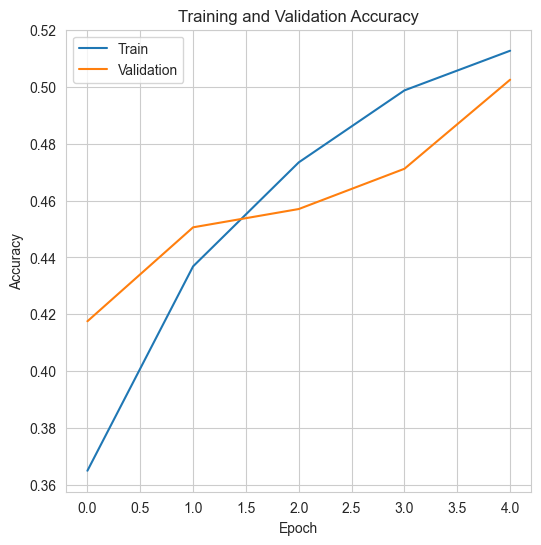

In [119]:
# Plot the training and validation accuracy
plt.figure(figsize=(6, 6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

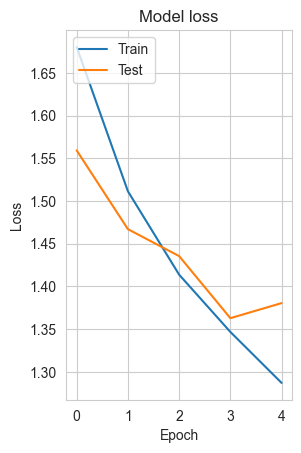

In [120]:
# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()

73/73 [==============================] - 0s 5ms/step
              precision    recall  f1-score   support

           0       0.39      0.83      0.53       494
           1       0.69      0.76      0.72       422
           2       0.61      0.23      0.34       396
           3       0.43      0.43      0.43       272
           4       0.39      0.23      0.29       227
           5       0.47      0.09      0.14       258
           6       0.75      0.61      0.67       259

    accuracy                           0.50      2328
   macro avg       0.53      0.45      0.45      2328
weighted avg       0.54      0.50      0.47      2328



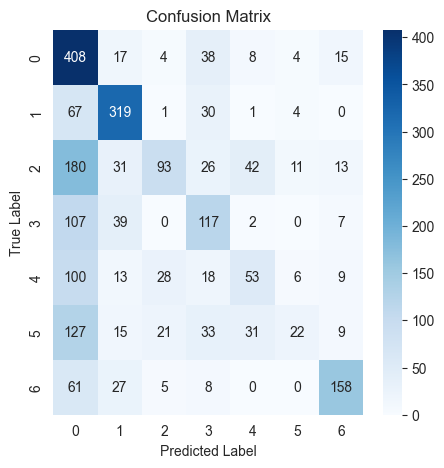

In [121]:
# Predict classes
pred_classes = np.argmax(model.predict(test_x), axis=-1)

# Print the Classification Report
print(classification_report(test_y, pred_classes))

# Create the Confusion Matrix
cm = confusion_matrix(test_y, pred_classes)

# Display the Confusion Matrix
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()